# Fusion of Physical Mechanism for Predicting Complex Flow Temperature Fields

## Overview

In the field of engineering, the prediction of temperature fields under complex flow conditions has attracted widespread attention. Especially in situations where there are numerous discrete heat sources/cold sources distributed in space, the coupling effect between these heat sources and the working fluid flow not only increases the design freedom of the research object but also significantly increases the complexity and time cost required for computational fluid dynamics (CFD) simulations. For such problems, purely data-driven model construction often fails to achieve high-precision predictions and performs poorly in terms of extrapolation generalization, and its training process relies on a large amount of high-cost CFD data.
This study abstracts the traditional cold effect superposition formula (Seller's formula) and integrates it into the network structure to enhance the accuracy and generalization ability of the neural network in predicting temperature fields under complex flows, providing an efficient and reliable solution for dealing with highly complex temperature field prediction problems.


## Method

### Problem description

Deep learning techniques have great potential for predicting the effect of film cooling in gas turbine end-wall regions, especially when dealing with complex flow environments and geometric conditions. The numerical driven model can effectively reduce the computational cost and time, and predict the physical field distribution concerned by the designer with high accuracy within the training data distribution range (ID). However, it is impossible to include all possible designs in the data set when constructing a general-purpose film cooling prediction model, and fully data-driven models often show a sharp decline in prediction accuracy when facing samples beyond the training data distribution range (OOD).
This study proposes a strategy that blends traditional physical theory (such as Seller's formula) with neural operator networks. Seller's theorem is generalized and integrated into the network as a concrete structure. The model is trained and deduced by the strategy of "decomposition-compute-superposition". The above methods significantly improve the performance of the model in terms of prediction accuracy and extrapolation ability, and provide an efficient and reliable solution for dealing with highly complex temperature field prediction problems.

### Technical path

1. Construct operator neural network SDNO based on superposition principle. Its overall architecture is shown in the figure. The architecture consists of two key components: a computing network responsible for temperature field calculation based on the input of gas film pore configuration information, and a superposition network constructed according to Seller's formula to achieve superposition of physical field results. The fusion superposition principle of deep operator network describes in detail two different processing methods when the same sample is computed forward. The standard processing method (the black arrow path shown in the figure) only involves the use of computing network, while in the fusion superposition processing method (the blue arrow path shown in the figure), the entire process is divided into three key steps: "decomposition - calculation - superposition".

<div align="center">
<img alt="super_net_training" src="./images/super_net_training.png" width="500"/>
<div align="left">

2. Carry out network training based on the proposed superposition training strategy. The superposition network can be called many times in a forward computation. In addition, the same sample will participate in the training of model parameters in many different ways, which can effectively improve the generalization of the model. It also reduces the required sample requirements, which is particularly important in areas where data acquisition is expensive or data is scarce.

3. For the model after training with training data, only a small amount of data is used for further fine-tuning training of the superimposed network.


In [1]:
import os
import time
import argparse

from omegaconf import OmegaConf
import numpy as np
from mindspore import dtype as mstype
from mindspore import ops, context, save_checkpoint
from mindspore.amp import auto_mixed_precision, DynamicLossScaler
from mindflow.loss import RelativeRMSELoss
from mindflow.utils import load_yaml_config, print_log

### Training hyperparameters

Define a series of training hyperparameters, including: run model, run device, hyperparameter file path, etc.
Most network training hyperparameters are defined in the config.yaml file.
Set mindspore context based on training hyperparameters, set training mode, training equipment, etc.


In [2]:
def parse_args():
    """Parse input args"""
    parser = argparse.ArgumentParser(description="gvrb predict")
    parser.add_argument("--mode", type=str, default="PYNATIVE",
                        choices=["GRAPH", "PYNATIVE"], help="Running in GRAPH_MODE OR PYNATIVE_MODE")
    parser.add_argument("--device_target", type=str, default="Ascend", choices=["GPU", "Ascend", "CPU"],
                        help="The target device to run, support 'Ascend', 'GPU', 'CPU'")
    parser.add_argument("--device_id", type=int, default=7,
                        help="ID of the target device")
    parser.add_argument("--config_file_path", type=str,
                        default="configs/SPNO_pakB_test.yaml")
    input_args = parser.parse_args(args=[])
    return input_args


args = parse_args()
context.set_context(
    mode=context.GRAPH_MODE if args.mode.upper().startswith(
        "GRAPH") else context.PYNATIVE_MODE,
    device_target=args.device_target,
    device_id=args.device_id)
use_ascend = context.get_context(attr_key='device_target') == "Ascend"
compute_type = mstype.float16 if use_ascend else mstype.float32

### Configuration file import

Included in the training hyperparameter is the path to the config file through which to read the configuration file.
The file contains the specific parameters of the training, such as the learning rate, the number of iterations, the model structure, etc.


In [3]:
from src import init_record

config = OmegaConf.create(load_yaml_config(args.config_file_path))
record = init_record(args.config_file_path, record_name='pakb_train')

Configuration:
model_type: spno
spno:
  pred_model_name: unet
  super_model_name: fno
  in_channels: 10
  patch_num: 4
unet:
  in_channels: 10
  out_channels: 1
  channels: 20
  load_ckpt: none
fno:
  in_channels: 2
  out_channels: 1
  resolution:
  - 32
  - 32
  modes: 12
  channels: 20
  depths: 3
  load_ckpt: none
data:
  path: /data1/mqh/05_turbine/PR_files/turbine_endwall_fno/data
  type: pakb
  num_samples:
    train: 500
    test: 100
train:
  batch_size: 32
  hole_num_set:
  - 1
  - 2
  - 3
  - 5
  lr_init: 0.0001
  epochs: 300
  loss:
    type: RMSE
    normalize: false
    normalize_eps: 0.05
  optimizer: AdamW
  weight_decay: 0.0
  lr_scheduler:
    type: cos
    enable_warmup: true
    warmup_epochs: 10
  grad_clip_value: 1
test:
  batch_size: 16
  hole_num_set:
  - 1
  - 2
  - 3
  - 5
  - 10
  interval: 25
record_path: exp/pakb_super

Pid: 37424
Use Ascend: True


### Dataset

This study focuses on the gas film pore arrangement on the end wall of Pak-B blade. In previous studies on end-wall air film cooling, Pak-B blade profile has been widely adopted as a research object because of its typical structure and flow characteristics. The Pak-B blade components, flow passage, air film holes on the end wall and cold air chamber under the end wall are shown in Figure 1. Numerical calculations were performed using commercial CFD software Star-CCM+.

<div align="center">
<img alt="computation_domain" src="./images/computation_domain.png" width="500"/>
<div align="left">

In this study, a non-mixing strategy was adopted in the composition of the data set, that is, samples with different numbers of gas film pores were strictly distinguished.
A series of geometric models with different number of gas film holes are generated by using the proposed high degree of freedom gas film hole configuration parameterization method. Specifically, 600 sets of data samples were generated for configurations with the number of gas film holes being 1, 2, 3, and 5, respectively. For the case of a large number of gas film holes, that is, the configuration of 10, 15, 20 holes, each generated 110 sets of samples. These data samples are used to obtain the temperature field distribution on the turbine end wall through the numerical calculation method established.
In general, the 2730 sets of data prepared were divided into three subsets: a training set consisting of 2000 samples, including samples with the number of gas film holes 1, 2, 3, and 5, with 500 in each configuration; A validation set consisting of 700 samples covering all gas film pore number configurations, 100 of each configuration; Finally, a fine-tuned test set of 30 samples was developed specifically for a higher number of gas film pore configurations.

<div align="center">
<img alt="data_set" src="./images/data_set.png" width="500"/>
<div align="left">

The loaddataset function is used to load the dataset into memory and return the data loader.
It is worth noting that the hole_num_set parameter in the configuration file sets the specific sample types to be used in training and testing.
For example: config.train.hole_num_set = [1, 2, 3, 5] refers to the sample of 1, 2, 3, 5 gas film holes used in training. These samples are mixed and scrambled in a dataloader.
For example: config.test.hole_num_set = [3, 5, 10] refers to a sample that uses 3, 5, 10 gas film holes in the test. The samples are placed in separate Dataloaders and formed into a list.


In [4]:
from src import load_dataset, DataNormer
print_log(f"Loading data...")
data_loader_train, data_loader_test = load_dataset(
    config, save_path=record.npz_dir)
x_norm = DataNormer([], loading=True, save_path=os.path.join(
    record.npz_dir, 'x_norm.npz'))

Loading data...


### Build neural networks

In this paper, a new operator neural network based on superposition principle, called SDNO, is proposed.
SDNO consists of prediction network and overlay network. The specific forms of the two networks need to be configured in the config file.
Generally, shallow FNO networks are used as overlay networks. patch_num in the network definition refers to the number of blocks in each spatial dimension during the overlay process.
The superposition principle used in this paper, also known as Seller's theorem, is a commonly used empirical formula in the cooling field, which is specifically expressed as follows:

$$  \eta (\omega ) = {({T_\infty } - T(\omega ))}/{({{T_\infty } - {T_c}})}\\
1 - {\eta ^{(AB)}}(\omega ) = (1 - {\eta ^{(A)}}(\omega )) \cdot (1 - {\eta ^{(B)}}(\omega ))$$

After parameter calibration of the formula, the following form can be obtained:

$$\text{origin: } T^{(AB)}(\omega) =  T^{(A)}(\omega) \oplus_\text{seller} T^{(B)}(\omega)$$

$$\text{calibrated: } T^{(AB)}(\Omega_p) =  T^{(A)}(\Omega_p) \hat{\oplus}_\text{super}(\theta_S) T^{(B)}(\Omega_p)$$

In the original formula, superposition is achieved by a fixed binary operator. Here it becomes a binary operator with tunable parameters.
On the other hand, the original superposition only uses information on the same spatial coordinate, which is adjusted to a subspace on the end wall to better handle coupling effects.
After the above parameterized calibration formula is expressed as the FNO network in SPNO2D class, it is practically equivalent to the windowed Fourier transform of the fixed sampling window


In [5]:
from src import get_model
model = get_model(config, compute_type)

### Optimizer and loss function
The loss function uses the mean square error, and the optimizer uses the Adam optimizer.
The details are defined in the config file.

In [6]:
from src import get_optimizer
loss_fn = RelativeRMSELoss(reduction='mean')
steps_per_epoch = data_loader_train.get_dataset_size()
optimizer = get_optimizer(model, config, steps_per_epoch, optimizer_num=2)
if use_ascend:
    loss_scaler = DynamicLossScaler(1024, 2, 100)
    auto_mixed_precision(model, 'O3')

### Forward Process
In the training process of SDNO network, as shown in the figure below, the superposition network can be invoked several times in a forward calculation;
<div align="center">
<img alt="superposition_example_1" src="./images/superposition_example_1.png" width="500"/>
<div align="left">

In [7]:
from src import padding_tensor


def forward_fn(inputs, outputs, super_times):
    channels = config.spno.in_channels * (2**super_times)
    inputs = padding_tensor(inputs, x_norm=x_norm,
                            shuffle=True, channel_num=channels)
    inputs = inputs.astype(dtype=compute_type)
    outputs = outputs.astype(dtype=compute_type)
    pred = model(inputs)
    loss = loss_fn(pred, outputs)
    if use_ascend:
        loss = loss_scaler.scale(loss)
    return loss, pred


grad_fn_0 = ops.value_and_grad(
    forward_fn, None, optimizer[0].parameters, has_aux=True)
grad_fn_1 = ops.value_and_grad(
    forward_fn, None, optimizer[1].parameters, has_aux=True)
grad_fn_tuple = (grad_fn_0, grad_fn_1)


def train_step(inputs, outputs):
    inputs = inputs.astype(compute_type, copy=True)
    outputs = outputs.astype(compute_type, copy=True)
    loss, pred, grads = [None, None], [None, None], [None, None]
    for i in [0, 1]:
        (loss[i], pred[i]), grads[i] = grad_fn_tuple[i](inputs, outputs, i)
        if use_ascend:
            loss[i] = loss_scaler.unscale(loss[i])
            grads[i] = loss_scaler.unscale(grads[i])
        loss[i] = ops.depend(loss[i], optimizer[i](grads[i]))
    return loss[0].asnumpy(), loss[1].asnumpy()

### Define the training process
Errors are calculated for both the training set and the test set, using the test function, before the training begins and after each 25 epochs are trained.
During training, after training 25 epochs, the model is saved to a ckpt file.
The tests and records are based on the config file parameter config.test.interval.

In [8]:
from src import inference_loop


def train():
    print_log('training...')
    loss_step = {'train': [], 'test': []}
    for epoch in range(1 + config.train.epochs):
        # test
        if epoch % config.test.interval == 0 or epoch == config.train.epochs:
            loss_step['train'].append(
                test(data_loader_train, prefix="train", epoch=epoch, super_times=0))
            loss_step['train'].append(
                test(data_loader_train, prefix="train", epoch=epoch, super_times=1))
            loss_step['test'].append(
                test(data_loader_test, prefix="test", epoch=epoch, super_times=0))
            loss_step['test'].append(
                test(data_loader_test, prefix="test", epoch=epoch, super_times=1))
            save_checkpoint(model, os.path.join(record.ckpt_model))

        local_time_beg = time.time()
        model.set_train()
        loss_all = [[], []]

        for data_tuple in data_loader_train:
            loss_0, loss_1 = train_step(*data_tuple)
            loss_all[0].append(loss_0)
            loss_all[1].append(loss_1)

        loss_0 = np.mean(loss_all[0])
        loss_1 = np.mean(loss_all[1])
        print_log(
            f"Epoch {epoch}: loss_0 {loss_0:>10f} and loss_1 {loss_1:>10f}")
        epoch_seconds = time.time() - local_time_beg
        step_seconds = epoch_seconds / steps_per_epoch
        print_log(
            f"Train epoch time: {epoch_seconds:>5.3f} s, per step time: {step_seconds* 1000:>5.3f} ms")

    print_log("training done!")


def test(data_loader, prefix="train", epoch=0, super_times=0):
    if not isinstance(data_loader, list):
        data_loader = [data_loader]
    l2_error_list = inference_loop(
        model, data_loader, compute_type=compute_type, x_norm=x_norm, super_times=super_times)
    for idx, l2_error in enumerate(l2_error_list):
        print_log(
            f"Epoch {epoch}: {prefix}-{idx}-st={super_times} is {np.array(l2_error).mean()}")
    return l2_error_list

### Training process output
After the training is started, the config parameters and model information is printed first.
After the training starts, the loss value of each iteration is output.
After the training is complete, the training duration is displayed.
The printed content is saved to the result.log file.

In [ ]:
start_time = time.time()
train()
print_log(f"End-to-End total time: {time.time() - start_time} s")

training...
Epoch 0: train-0-st=0 is 1.1443806886672974
Epoch 0: train-0-st=1 is 1.1438467502593994
Epoch 0: test-0-st=0 is 1.199528455734253
Epoch 0: test-1-st=0 is 1.1701231002807617
Epoch 0: test-2-st=0 is 1.0940465927124023
Epoch 0: test-3-st=0 is 1.0093998908996582
Epoch 0: test-4-st=0 is 1.2407870292663574
Epoch 0: test-0-st=1 is 1.1952192783355713
Epoch 0: test-1-st=1 is 1.1628490686416626
Epoch 0: test-2-st=1 is 1.0955628156661987
Epoch 0: test-3-st=1 is 1.0105085372924805
Epoch 0: test-4-st=1 is 1.238897681236267
Epoch 0: loss_0   1.084033 and loss_1   0.999251
Train epoch time: 202.372 s, per step time: 3212.254 ms
Epoch 1: loss_0   0.821608 and loss_1   0.987154
Train epoch time: 96.602 s, per step time: 1533.366 ms
Epoch 2: loss_0   0.698258 and loss_1   0.975826
Train epoch time: 96.854 s, per step time: 1537.360 ms
Epoch 3: loss_0   0.613517 and loss_1   0.963115
Train epoch time: 97.105 s, per step time: 1541.348 ms
Epoch 4: loss_0   0.533393 and loss_1   0.947637
Train 

: 

: 

## Model Inference
You can invoke the run_inference.py file to predict any sample in the design space and save the inference result as an .npz file.
During inference, set args.config_file_path to the path of a local record that has been trained.

In [11]:
from src import load_record, run_inference

record = load_record('./exp/pakb_inference') # use your own record path
print_log("inferencing...")
run_inference(config, record)
print_log("inferencing done!")

inferencing train dataset...
inferencing test dataset...
inferencing done!


## Visualization of training results
Invoking the inference.py file can make predictions about arbitrary samples in the design space and save the inference results as npz files.
Further, you can use the drawing function draw_field to visualize the result of the inference.


visualizing...


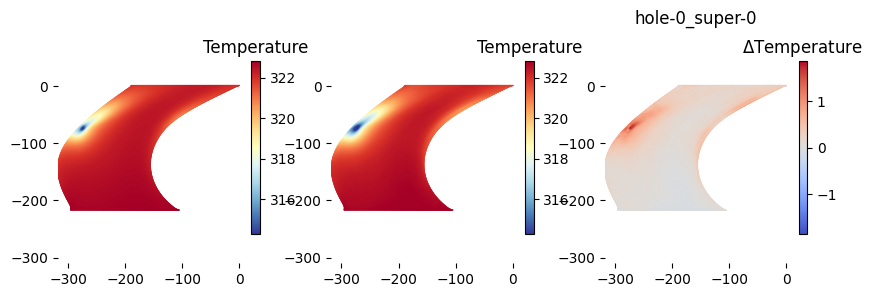

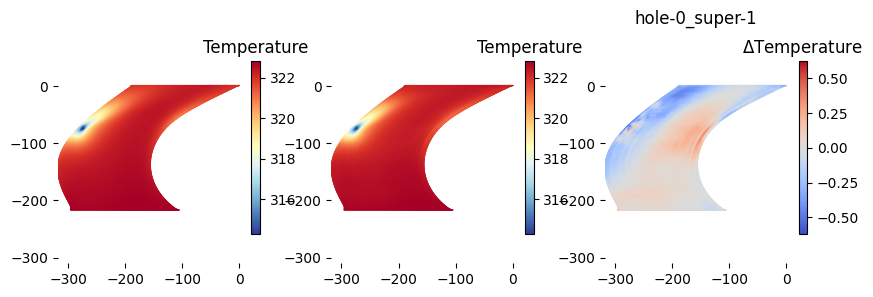

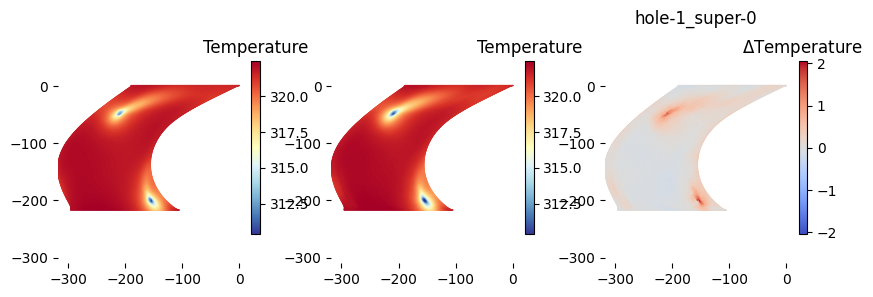

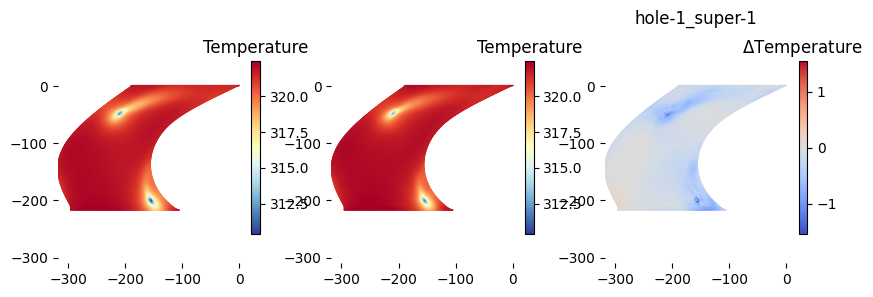

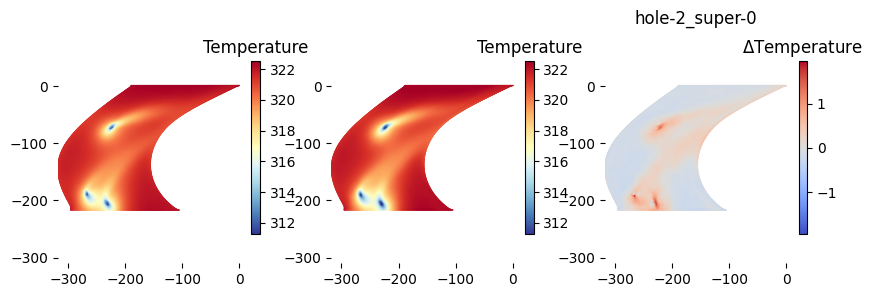

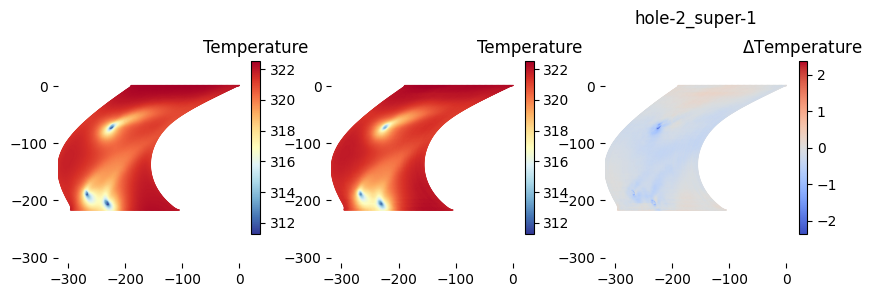

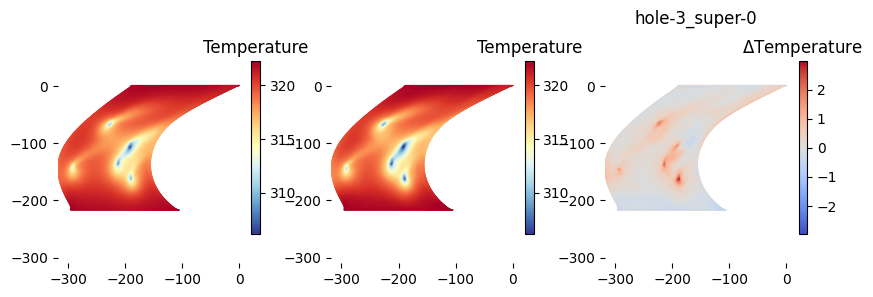

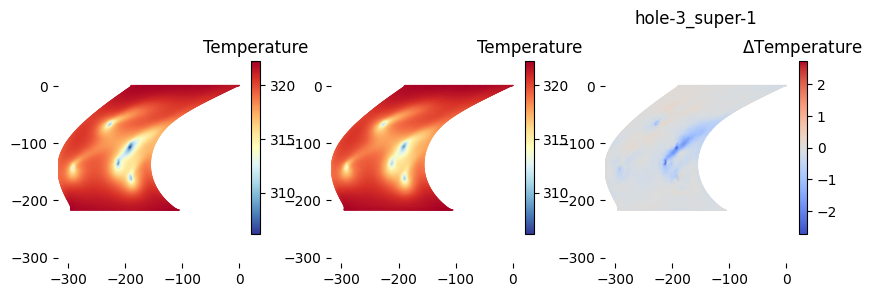

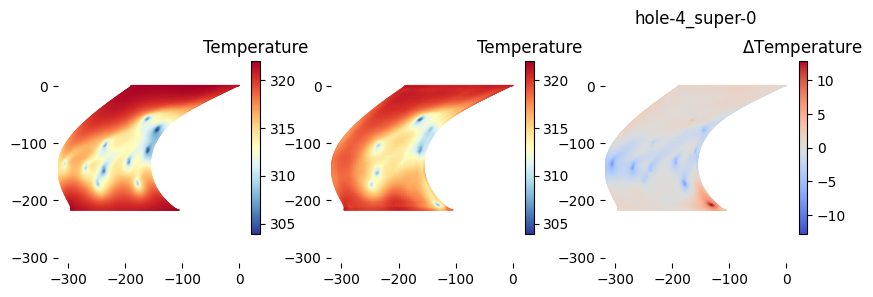

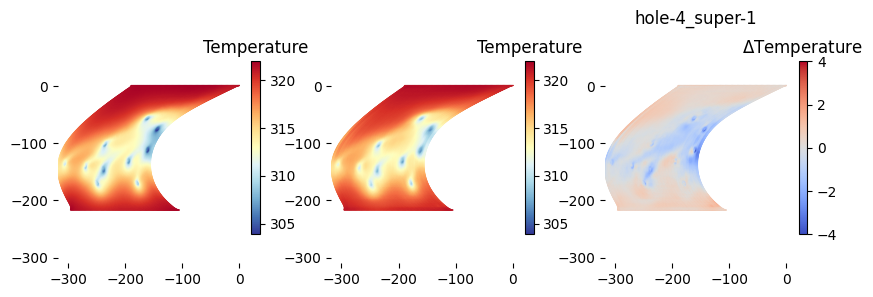

visualizing done!


In [11]:
from src import run_visualization
print_log("visualizing...")
run_visualization(record, save_path='show')
print_log("visualizing done!")